In [313]:
%matplotlib inline
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.inspection import DecisionBoundaryDisplay  # Does not work on Google Collab
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from scipy.stats import mode
from sklearn.base import clone
from sklearn.datasets import load_iris
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.tree._tree import TREE_UNDEFINED
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from matplotlib.colors import LogNorm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score, roc_curve, silhouette_samples

plt.rcParams["figure.figsize"] = (12, 8)

In [248]:
loaded = Table.read("Data_100kstars_100kgalaxies_100kquasars.fits", format="fits")
loaded

source_id,random_index,ra,dec,b,parallax,pm,astrometric_chi2_al,astrometric_n_good_obs_al,phot_g_n_obs,phot_g_mean_flux_over_error,phot_g_mean_mag,bp_g,g_rp,quasar,galaxy,star,classification,uwe,relvarg,sinb
int64,int64,float64,float64,float64,float64,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,bytes6,float32,float32,float64
1265515347877933440,10075,222.2748877964174,22.198160757624645,62.88185687555298,-0.33668980134029775,0.7173173,2874.5293,557,540,134.34177,17.933859,-2.318183,3.621396,2.2420623e-11,1.0,1.0961916e-10,galaxy,2.2819905,2.7369614,0.8900685083805976
5361196917262946432,15072,162.2255880878679,-49.75239367222261,8.437575826696916,-0.03670704081825209,5.728018,163.85497,119,103,77.48301,19.842285,-2.7583504,4.355935,9.393035e-12,0.9991883,0.0008117138,galaxy,1.1988846,1.976093,0.14673178355667238
1232222032709253760,21887,214.14998079670747,16.513552038185832,67.61610494550179,1.771743674736804,2.9129527,500.0566,211,261,91.17528,20.476004,-1.0306759,2.3467827,2.140544e-05,0.9999388,3.978026e-05,galaxy,1.5580306,2.1101627,0.9246531099969133
2036211254522971136,31435,288.127523847601,26.28806110552507,7.393590050282927,-0.2814277361136858,5.7879395,358.1406,344,337,204.91426,20.34236,--,--,3.905006e-32,0.99990237,9.763462e-05,galaxy,1.0278434,3.173843,0.12868465283078245
1508859364417098624,48386,210.6647188658992,46.20634448793206,66.28707227872079,-0.2998018859774316,0.6104444,1701.7203,393,523,102.935295,18.904287,-1.698452,2.9888058,6.760223e-08,0.9999999,2.4985818e-08,galaxy,2.0942485,2.333469,0.9155718780325535
1253126291374182656,54587,215.17304544205666,23.28879425028681,69.47886314381957,2.060774528752372,1.5780792,862.20404,228,230,67.8532,20.62693,-0.9972191,2.4398327,0.00013327254,0.9997067,0.0001600439,galaxy,1.9663128,1.8137101,0.9365429313026993
6412316770552882048,58708,328.99726131069883,-57.745577203863824,-46.725313011611185,0.7742238830480377,2.344511,839.3004,251,253,105.85602,20.31666,-1.1405315,2.5691051,0.00016996324,0.9996806,0.0001494562,galaxy,1.8471032,2.2826095,-0.7280756780138176
645184597022258688,61549,142.375307507671,23.957886654723634,44.64092599049423,-4.028053405917453,1.1013553,845.6057,263,268,100.34398,20.48668,-1.3336506,2.5588398,2.2043196e-07,0.9998569,0.00014286296,galaxy,1.8103982,2.213145,0.7026614692499646
4450399555400689792,72957,243.98649098858175,7.707625288970774,37.927393114095,-0.26981241520395144,1.5136069,1324.708,374,402,203.34277,19.68747,-1.105545,2.5973911,1.7744916e-05,0.99998116,1.0619076e-06,galaxy,1.8947282,3.2138042,0.614662391005288


In [250]:
print(loaded.colnames)

['source_id', 'random_index', 'ra', 'dec', 'b', 'parallax', 'pm', 'astrometric_chi2_al', 'astrometric_n_good_obs_al', 'phot_g_n_obs', 'phot_g_mean_flux_over_error', 'phot_g_mean_mag', 'bp_g', 'g_rp', 'quasar', 'galaxy', 'star', 'classification', 'uwe', 'relvarg', 'sinb']


In [252]:
features = ['sinb', 'parallax', 'pm', 'uwe', 'phot_g_mean_mag', 'bp_g', 'g_rp', 'relvarg']

from astropy.table import MaskedColumn

# Convert all columns in the table to MaskedColumn type
for colname in loaded.colnames:
    loaded[colname] = MaskedColumn(loaded[colname])

filled_columns = [loaded[feature].filled(np.nan) for feature in features]

# Stacking the filled columns into a NumPy array
x = np.vstack(filled_columns).T


y = loaded['classification']

mask = ~np.isnan(x).any(axis=1)
x = x[mask]
y = y[mask]
y = np.array([label.decode() if isinstance(label, bytes) else label for label in y])
print(x.shape)


(280585, 8)


In [253]:
labels, counts = np.unique(y, return_counts=True)
for label, count in zip(labels, counts):
    print(f"Label {label}: {count} samples")

Label galaxy: 85342 samples
Label quasar: 96783 samples
Label star: 98460 samples


# Using 1 Decision Tree

In [263]:
tree = DecisionTreeClassifier(max_depth = 3, random_state = 0)
#Depth is the number of binary questions 
tree.fit(x, y)

DecisionTreeClassifier(max_depth=3, random_state=0)

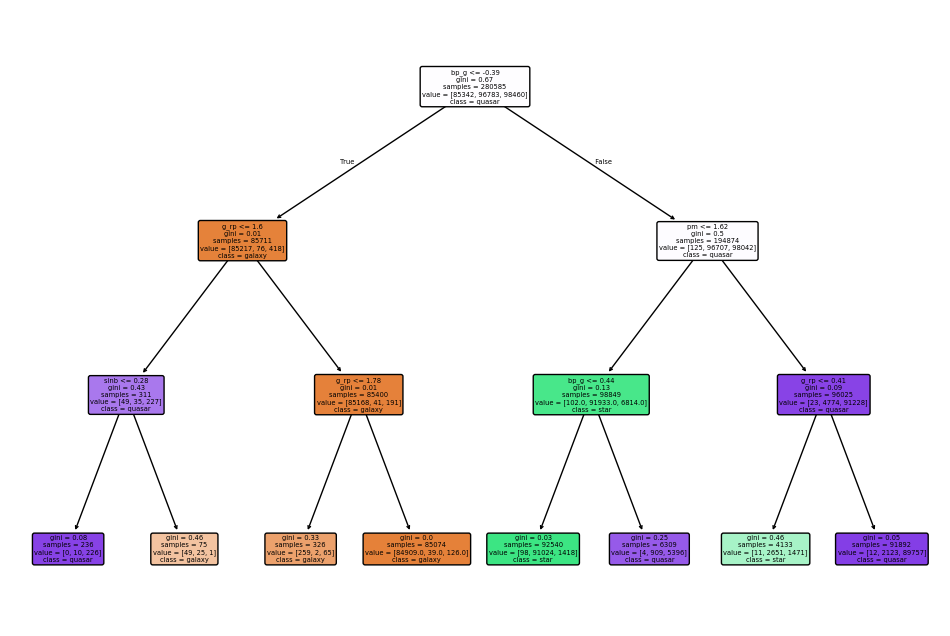

In [264]:
fig = plot_tree(tree, feature_names = features, class_names = ['galaxy', 'star', 'quasar'],
                filled = True, rounded = True, precision = 2)

# Using only 2 features

In [ ]:
features2 = ['bp_g', 'g_rp']

filled_columns2 = [loaded[feature].filled(np.nan) for feature in features2]

x2 = np.vstack(filled_columns2).T

y = loaded['classification']

mask = ~np.isnan(x2).any(axis=1)
x2 = x2[mask]
print(len(x2))
y = y[mask]
y = np.array([label.decode() if isinstance(label, bytes) else label for label in y])

labels, counts = np.unique(y, return_counts=True)
for label, count in zip(labels, counts):
    print(f"Label {label}: {count} samples") 
    
tree = DecisionTreeClassifier(max_depth = 3, random_state = 0)
#Depth is the number of binary questions 
tree.fit(x2, y)


colors =[]
for i in range(len(y)):
    if y[i] == 'star':
        colors.append(0)
    if y[i] == 'galaxy':
        colors.append(1)
    else:
        colors.append(2)

disp = DecisionBoundaryDisplay.from_estimator(tree, x2, response_method = 'predict', xlabel = 'bp_g', ylabel = 'g_rp',
                                              alpha = 0.5)

disp.ax_.scatter(x2[:,0], x2[:, 1], c = colors, edgecolors = 'k', marker ='o', alpha = 0.5)

plt.title('Decision Boundaries of the Decision Tree')
plt.show()

# Random Forest

In [269]:
clf = RandomForestClassifier(n_estimators = 500, 
                        max_leaf_nodes= 16, n_jobs = -1, random_state= 1337)

In [271]:
# Convert byte labels to strings
y = np.array([label.decode() if isinstance(label, bytes) else label for label in y])

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 1337)
print(x_train.shape)

(210438, 8)


In [273]:
clf.fit(x_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1,
                       random_state=1337)

In [ ]:
cv grid search

In [275]:
print(clf.score(x_test, y_test))

0.9950675011048228


In [277]:
for name, importance in zip(features, clf.feature_importances_):
    print(f"{name}: {importance:.4f}")

sinb: 0.0778
parallax: 0.0074
pm: 0.1874
uwe: 0.1270
phot_g_mean_mag: 0.0082
bp_g: 0.3050
g_rp: 0.2389
relvarg: 0.0482


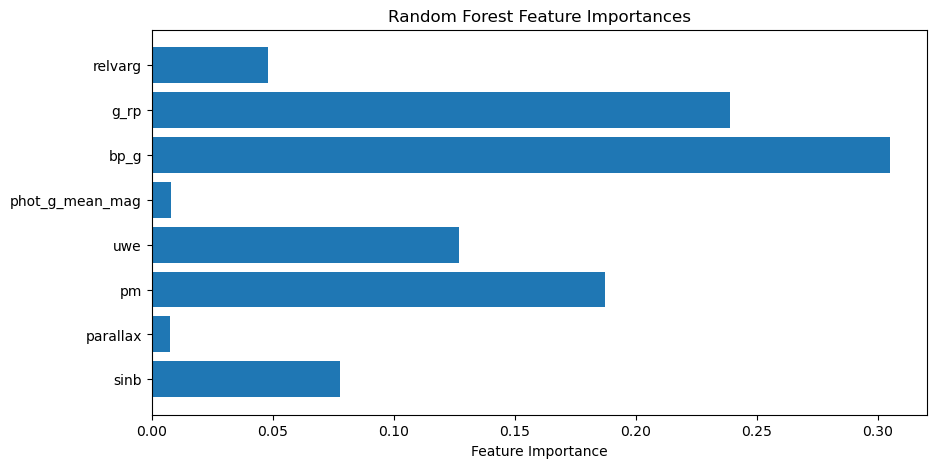

In [279]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.barh(features, clf.feature_importances_)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.show()


In [281]:
from sklearn.metrics import classification_report

y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

      galaxy       1.00      1.00      1.00     21420
      quasar       0.99      0.99      0.99     24094
        star       0.99      0.99      0.99     24633

    accuracy                           1.00     70147
   macro avg       1.00      1.00      1.00     70147
weighted avg       1.00      1.00      1.00     70147



In [283]:

y_test = np.array(y_test)
y_pred = np.array(y_pred)

labels_true, counts_true = np.unique(y_test, return_counts=True)
labels_pred, counts_pred = np.unique(y_pred, return_counts=True)

print("True label counts:")
for label, count in zip(labels_true, counts_true):
    print(f"  {label}: {count}")

print("Predicted label counts:")
for label, count in zip(labels_pred, counts_pred):
    print(f"  {label}: {count}")


True label counts:
  galaxy: 21420
  quasar: 24094
  star: 24633
Predicted label counts:
  galaxy: 21464
  quasar: 24080
  star: 24603


## Hyperparameter Tuning

In [315]:
params = {'n_estimators': list(range(100, 1000)),
'max_depth': list(range(1, 10)),
'min_samples_split': [2, 3, 4]
}
search = RandomizedSearchCV(RandomForestClassifier(random_state=42),
params,
cv=3)


In [317]:
search.fit(x_train, y_train)
print(accuracy_score(y_train, search.predict(x_train)))

0.9985126260466266


In [319]:
print("Best hyperparameters:", search.best_estimator_)
print("Best scores:", search.best_score_)

# Test set evaluation
best_model = search.best_estimator_

Best hyperparameters: RandomForestClassifier(max_depth=8, n_estimators=623, random_state=42)
Best scores: 0.9982180024520285


In [321]:
best_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=623, random_state=42)

In [323]:
print(best_model.score(x_test, y_test))

0.9982750509644033


In [325]:
for name, importance in zip(features, best_model.feature_importances_):
    print(f"{name}: {importance:.4f}")

sinb: 0.0748
parallax: 0.0077
pm: 0.1952
uwe: 0.1165
phot_g_mean_mag: 0.0083
bp_g: 0.3099
g_rp: 0.2437
relvarg: 0.0439


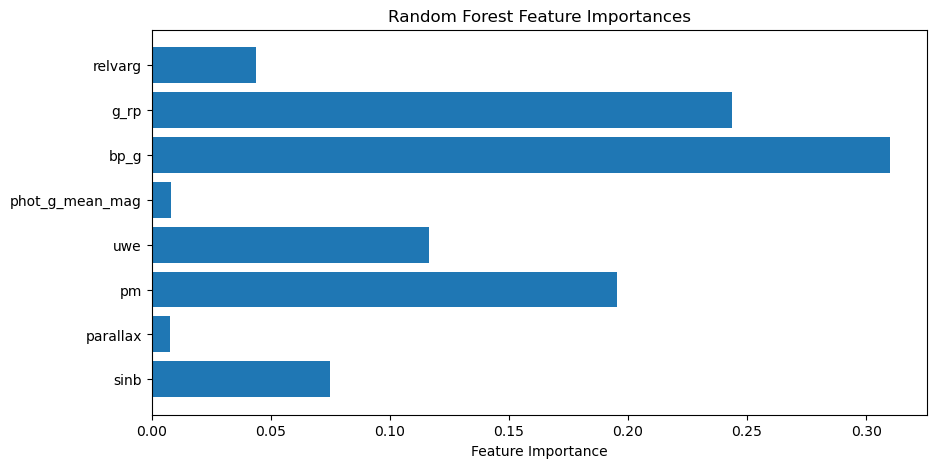

In [327]:


plt.figure(figsize=(10,5))
plt.barh(features, best_model.feature_importances_)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.show()


In [329]:
y_pred = best_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      galaxy       1.00      1.00      1.00     21420
      quasar       1.00      1.00      1.00     24094
        star       1.00      1.00      1.00     24633

    accuracy                           1.00     70147
   macro avg       1.00      1.00      1.00     70147
weighted avg       1.00      1.00      1.00     70147



In [331]:
y_test = np.array(y_test)
y_pred = np.array(y_pred)

labels_true, counts_true = np.unique(y_test, return_counts=True)
labels_pred, counts_pred = np.unique(y_pred, return_counts=True)

print("True label counts:")
for label, count in zip(labels_true, counts_true):
    print(f"  {label}: {count}")

print("Predicted label counts:")
for label, count in zip(labels_pred, counts_pred):
    print(f"  {label}: {count}")

True label counts:
  galaxy: 21420
  quasar: 24094
  star: 24633
Predicted label counts:
  galaxy: 21438
  quasar: 24144
  star: 24565
